# VCF files and F statistics

In this session we will analyze variants called for our dataset of 28 individuals from across the world, as introduced in the first notebook `01_mapping_and_calling`. To perform this variant analysis we will make use of a `VCF` file, such as the one generated in the previous notebook, but including all 28 samples, thus making possible the study of population genetic's summary statistics from the variants called. Additionally, we will need the metadata file for annotating the samples in the VCF file. The VCF and metadata files are found in `Data/vcf/chr2_135_145.vcf.gz` and `Data/metadata/sample_infos_accessionnb.csv`.


## Content

We will explore the VCF file and work on the summary statistic $F_{ST}$, which is the proportion of the total genetic variance contained in a subpopulation (the S subscript) relative to the total genetic variance (the T subscript). Values can range from 0 to 1. High $F_{ST}$ implies a considerable degree of differentiation among populations.

The code is mostly base on the `R` language, and we will use some useful packages such as

- [dplyr](https://cran.r-project.org/web/packages/dplyr/vignettes/dplyr.html) and [ggplot](https://monashbioinformaticsplatform.github.io/r-more/topics/tidyverse.html) for easily handling data tables and plotting
- [vcfR](https://cran.r-project.org/web/packages/vcfR/vignettes/intro_to_vcfR.html) to import vcf files into `R`.

## How to make this notebook work

* In this notebook we will use primarily `R` and shortly `command line bash` commands to setup the file folders.
* Having to shift between two languages, you need to choose a kernel every time we shift from one language to another. A kernel contains a programming language and the necessary packages to run the course material. To choose a kernel, go on the menu on the top of the page and select `Kernel --> Change Kernel`, and then select the preferred one. We will shift between two kernels, and along the code in this notebook you will see a picture telling you to change kernel. The two pictures are below:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel
* You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
* You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
* The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 


## Learning outcomes

At the end of this tutorial you will be able to

- **Import** vcf files and **explore** its content to be used for analysis
- **Calculate and visualize** population genetics' statistics
- **Understand and generalize** commands to filter and manipulate dataframes

## Setting up folders

Here we setup a link to the `Data` folder. It is the only time where we use the command line kernel.

<img src="img/bash.png" alt="Bash" width="80"> Choose the `Bash` kernel

In [1]:
ln -s ../../Data

<img src="img/R.png" alt="R" width="80"> Choose the `popgen course` kernel

In [1]:
library(ggplot2)
library(dplyr)
library(vcfR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



   *****       ***   vcfR   ***       *****
   This is vcfR 1.13.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




Import the vcf file using `vcfR`

In [4]:
vcf <- read.vcfR("Data/vcf/chr2_135_145.vcf.gz")

Scanning file to determine attributes.
File attributes:
  meta lines: 47
  header_line: 48
  variant count: 49868
  column count: 37
Meta line 47 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 49868
  Character matrix gt cols: 37
  skip: 0
  nrows: 49868
  row_num: 0
Processed variant: 49868
All variants processed


Here we extract some fields from the VCF that might be of usage when doing some QC analysis. We can extract per position variables (info fields), e.g:

- TR : Total number of reads containing this variant.

Or per position and per sample variables (format fields), e.g:
- GT : genotype.
- GQ : genotype quality.
- NR : number of reads covering variant location in this sample.

Inspect the VCF file header to select other variables of interest. Here, we are only going to use the genotypes. The command `vcfR2tidy` converts chosen fields of the VCR file into a `tidy` dataframe on which you can do analysis in `R`.

In [6]:
tvcf <- vcfR2tidy(vcf, 
          single_frame = TRUE,
          info_fields = c("TR"),
          format_fields = c("GT","GQ","NR"),
          info_types = TRUE,
          format_types = c(NR="i",GQ="i"))

Extracting gt element GT

Extracting gt element GQ

Extracting gt element NR



One of the measures provided for each variant call is the Phred score, i.e the quality associated with that given base pair. It is computed by the following equation:

$Q = -10 log10(P)$

Being P the probability of error of a given the base call.

We add the metadata containing the population and region of each sample. We also convert heterozygouss genotypes to a common format. When we have phased data (next week), we know the parental and maaternal haplotypes and the order of 1 and 0, determines these haplotypes. Phased data is represented with "|" instead of "/". In this case, we have unphased data, but the algorithm might have randomly ordered the alleles, and we are only interested in the fact that they are heterozygous, thus we simplify the analysis by using a common representation.

In [7]:
info <- read.csv2("./Data/metadata/sample_infos_accessionnb.csv")
d <- inner_join(tvcf$dat,info, by= c("Indiv" = "ENA.RUN")) %>%
  mutate(gt_GT=replace(gt_GT, gt_GT=="1/0", "0/1"))

## PART I: VCF file exploration

We start the analysis by looking at the proportion of missing genotypes for each sample.

In [8]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  arrange(desc(missing))

Indiv,missing
<chr>,<dbl>
ERR1025639,1.0000000000
ERR1019039,0.0018448705
ERR1019075,0.0014438117
ERR1025624,0.0013836528
ERR1025598,0.0012232293
ERR1025657,0.0011029117
ERR1019076,0.0010026470
ERR1025610,0.0010026470
ERR1025658,0.0009424882


We find one individual that only has missing genotypes. This tells us that either there was no sequencing data for this individual, or that it was of poor quality and the alignment of the reads was completely unsuccesful.  

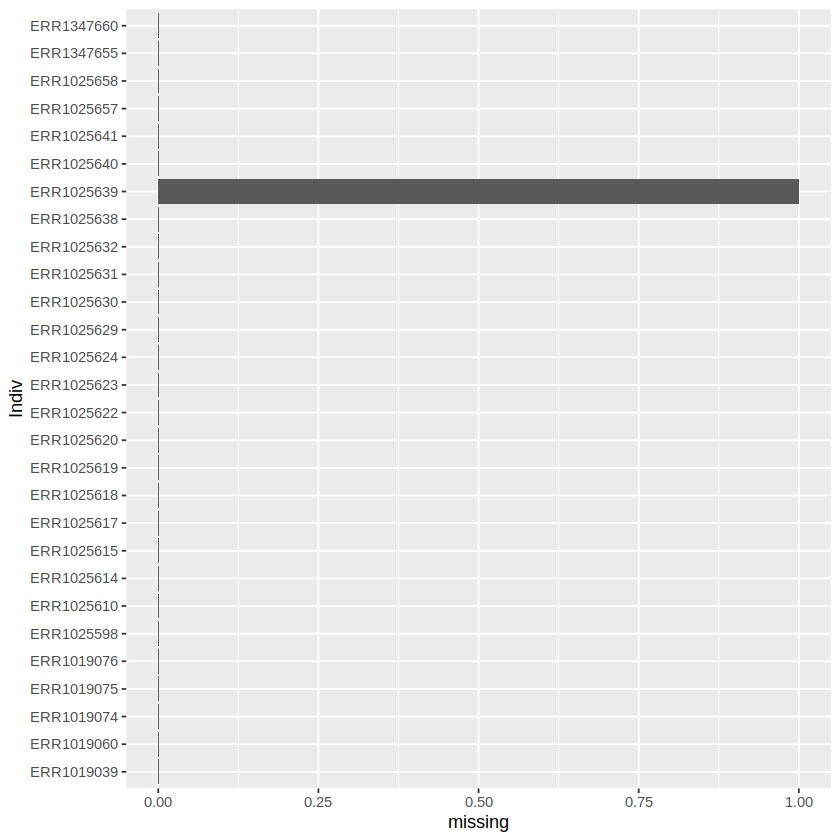

In [9]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  ggplot(aes(x=Indiv,y=missing)) + geom_col() + coord_flip()

In [11]:
d <- d %>% filter(Indiv!="ERR1025639")

### Q1. Which individual has the largest amount of missing data now?

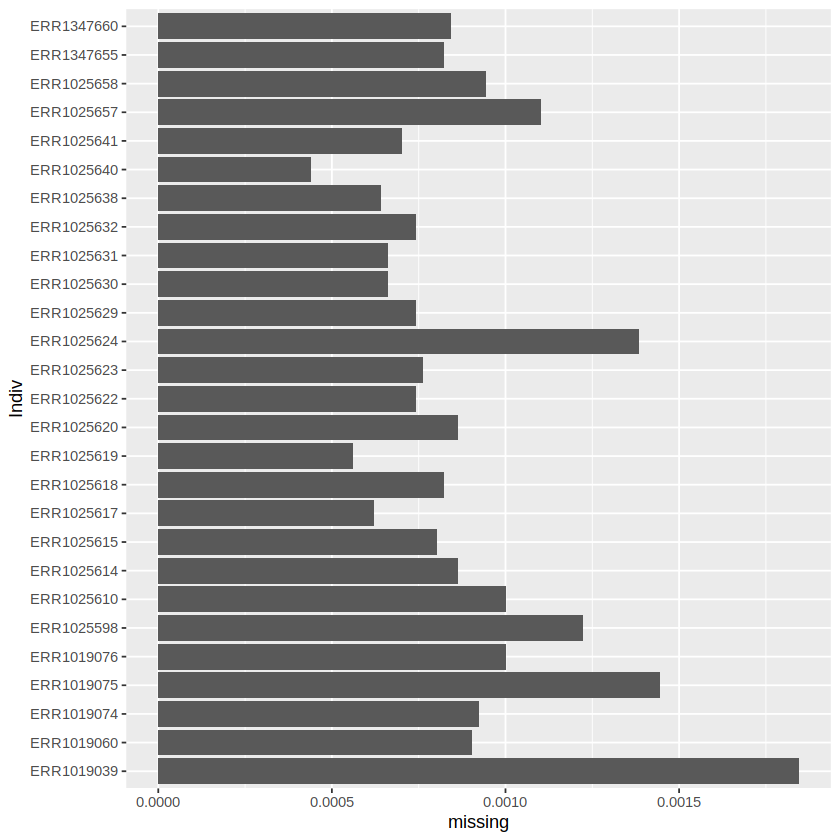

In [12]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  ggplot(aes(x=Indiv,y=missing)) + geom_col() + coord_flip()

Missing data is a sign of poor quality. It can be representative of poor sample quality or variant quality. Genotype algorithms generally include a set of variables and thresholding points to distinguish low quality variants from the rest. This is represented in the FILTER column. Generally, depending on your experiment, you would like to define your own quality filters, but is an informative start. 

To know the metrics used to define the FILTER column, you can inspect the header of the VCF file. In this case, we have the following:


FILTER=<ID=GOF,Description="Variant fails goodness-of-fit test.">

FILTER=<ID=badReads,Description="Variant supported only by reads with low quality bases close to variant position, and not present on both strands.">

FILTER=<ID=alleleBias,Description="Variant frequency is lower than expected for het">

FILTER=<ID=hp10,Description="Flanking sequence contains homopolymer of length 10 or greater">

FILTER=<ID=Q20,Description="Variant quality is below 20.">

FILTER=<ID=HapScore,Description="Too many haplotypes are supported by the data in this region.">

FILTER=<ID=MQ,Description="Root-mean-square mapping quality across calling region is low.">

FILTER=<ID=strandBias,Description="Variant fails strand-bias filter">

FILTER=<ID=SC,Description="Variants fail sequence-context filter. Surrounding sequence is low-complexity">

FILTER=<ID=QualDepth,Description="Variant quality/Read depth ratio is low.">

FILTER=<ID=REFCALL,Description="This line represents a homozygous reference call">

FILTER=<ID=QD,Description="Variants fail quality/depth filter.">


If we have any of these ID parameters, the variant does not pass the FILTER, and the ID indicates us why. Conversely, if the variant has a "PASS" on the FILTER column, it has passed these filters.

### Q2. Some variants have values different from "PASS" in the FILTER column. These variants should be removed. Does that change the fraction of missing data?

In [13]:
d <- d %>% filter(FILTER=="PASS")

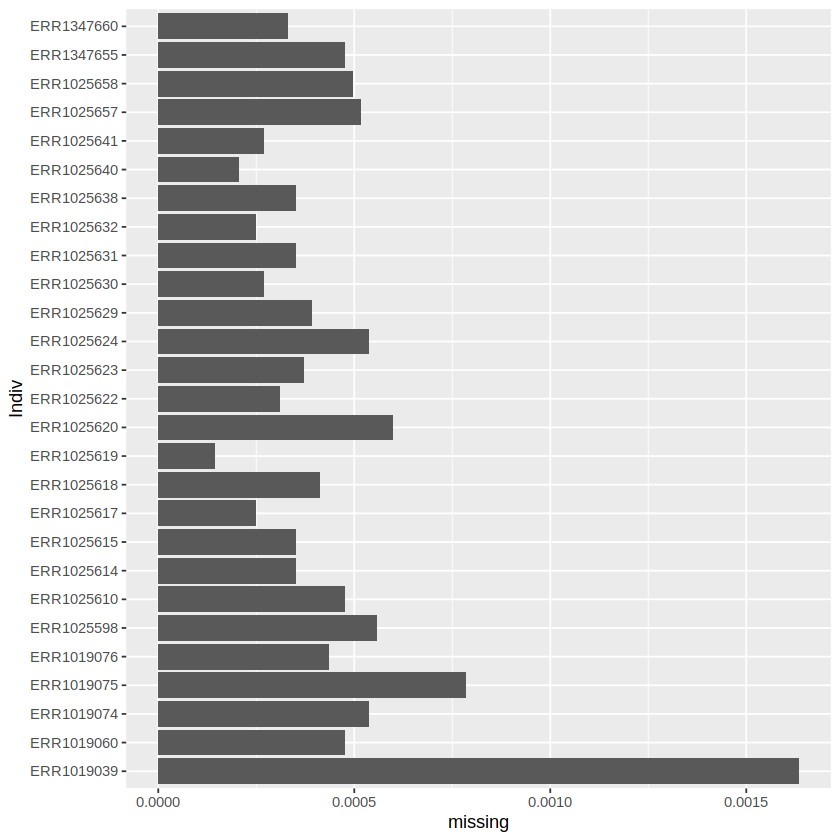

In [14]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  ggplot(aes(x=Indiv,y=missing)) + geom_col() + coord_flip()

### Q3. The column gt_NR contains the number of reads covering the position. What is the average depth in the data set?

In [15]:
mean(d$gt_NR)

[1] 37.38623

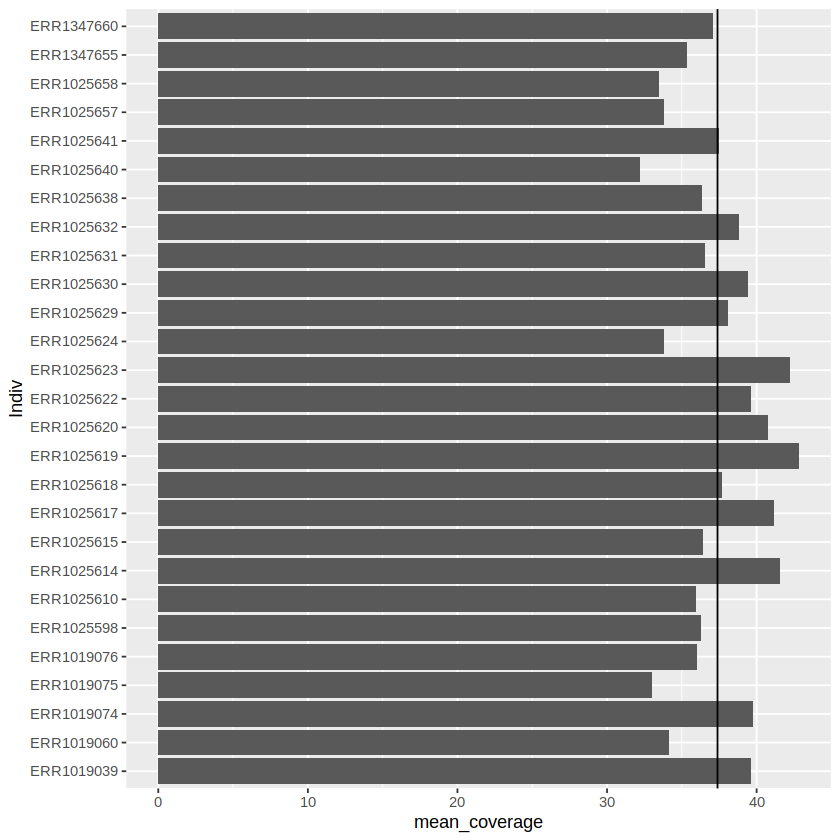

In [16]:
d %>% 
    group_by(Indiv) %>%
    summarise(mean_coverage = mean(gt_NR)) %>%
    ggplot(aes(x=Indiv,y=mean_coverage)) + geom_col() + geom_hline(yintercept = mean(d$gt_NR)) + coord_flip() 

Note how this matches the authors' note *"We sequenced the samples to an average coverage of 43-fold (range 34–83-fold) at Illumina Ltd; almost all samples (278) were prepared using the same PCR-free library preparation"* in https://www.nature.com/articles/nature18964

### Q4. If a variant is heterozygous the gt_GT variable will have the value "0/1". Make a plot of the number of variants that are heterozygous for each individual. Which population has the highest fraction of heterozygous variants in this genomic region?

In [17]:
names(d)

[1] "CHROM"         "POS"           "ID.x"          "REF"          
 [5] "ALT"           "QUAL"          "FILTER"        "TR"           
 [9] "Indiv"         "gt_GT"         "gt_GQ"         "gt_NR"        
[13] "gt_GT_alleles" "ID.y"          "population"    "region"       
[17] "country"       "latitude"      "longitude"     "Sex"          
[21] "Illumina.ID"

`summarise()` has grouped output by 'Indiv'. You can override using the
`.groups` argument.


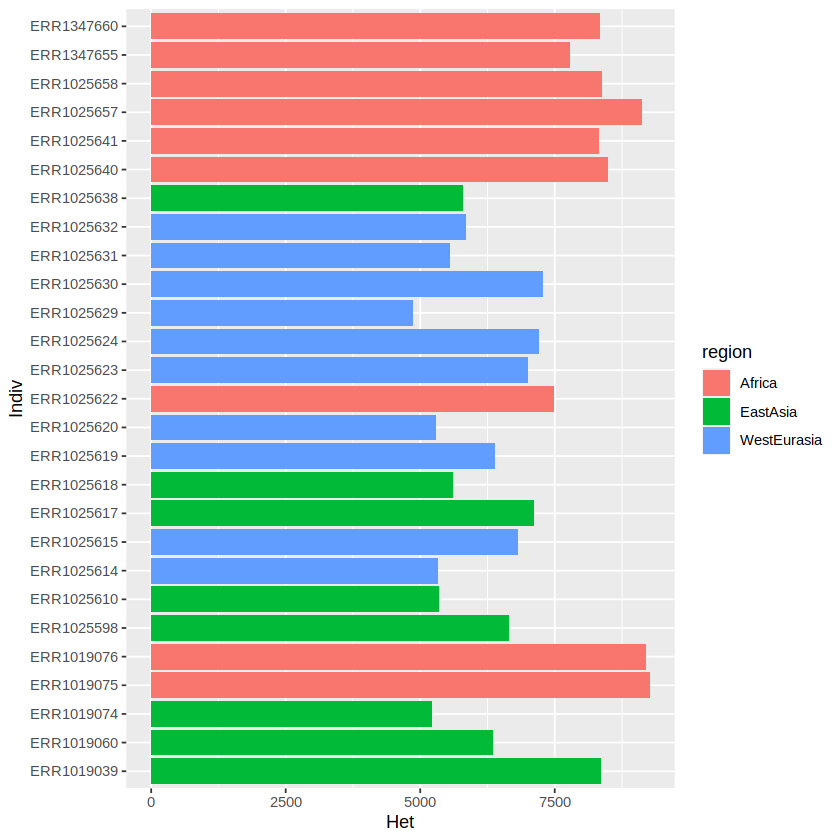

In [18]:
d %>% 
    filter(! is.na(gt_GT)) %>%
    group_by(Indiv,region) %>%
    summarise(Het = sum(gt_GT == "0/1")) %>%
    ggplot(aes(x=Indiv,y=Het, fill=region)) + geom_col() + coord_flip() 

## PART II: Population genetics statistics

Here we define the frequencies of each allele for each variant on each region.

In [19]:
d2 <- d %>%
  group_by(POS,region) %>%
  summarise(na=sum(gt_GT=="0/1",na.rm=T)+2*sum(gt_GT=="0/0",na.rm=T),
            nA=sum(gt_GT=="0/1",na.rm=T)+2*sum(gt_GT=="1/1",na.rm=T))  %>%
  mutate(pS=na/(na+nA), qS= nA/(na+nA))

`summarise()` has grouped output by 'POS'. You can override using the `.groups`
argument.


Here we plot the positions with polymoprhism for each region. As expected, Africa is the region with the highest polymorphism.

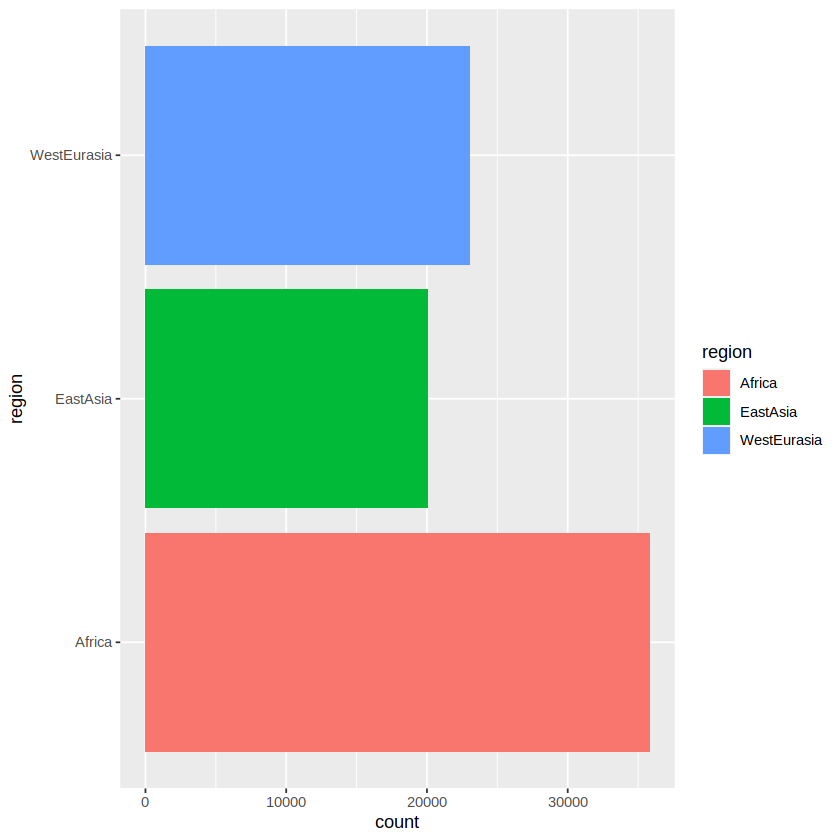

In [20]:
d2 %>% 
  filter(na!=0, nA!=0) %>%
  ggplot(aes(x=region, fill=region)) + geom_bar() + coord_flip()

The table used for the plot looks like this, and contains for each position and region the observed alleles and corresponding frequencies. Those can be used to calculate the $F_{st}$ statistics

In [21]:
head(d2)

POS,region,na,nA,pS,qS
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
135000277,Africa,14,4,0.7777778,0.2222222
135000277,EastAsia,16,0,1.0000000,0.0000000
135000277,WestEurasia,20,0,1.0000000,0.0000000
135000500,Africa,16,2,0.8888889,0.1111111
135000500,EastAsia,10,6,0.6250000,0.3750000
135000500,WestEurasia,4,16,0.2000000,0.8000000


### Q5. Use `d2` from above to calculate $F_{st}$ for each position. What is the median $F_{st}$ value?

To calculate $F_{st}$ we need to have the populations of interest grouped together, and then calculate $F_{st}=1-H_s/H_t$. Here, $H_s=mean(2\cdot p_s \cdot q_s)$, or the average of the heterozigosity calculated for each population, and $H_s=2\cdot mean(p_s) \cdot mean(q_s)$, or the expected heterozigosity for all the populations. Below, we use `group_by(POS)` to put together the populations at each locus, so that we have loci-wise values of the statistics. In the next cell of code, we will apply the median.

In [26]:
head( d2 %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) )

POS,region,na,nA,pS,qS,H_S,H_T,FST
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
135000277,Africa,14,4,0.7777778,0.2222222,0.1152263,0.1371742,0.1600000
135000277,EastAsia,16,0,1.0000000,0.0000000,0.1152263,0.1371742,0.1600000
135000277,WestEurasia,20,0,1.0000000,0.0000000,0.1152263,0.1371742,0.1600000
135000500,Africa,16,2,0.8888889,0.1111111,0.3287603,0.4898337,0.3288328
135000500,EastAsia,10,6,0.6250000,0.3750000,0.3287603,0.4898337,0.3288328
135000500,WestEurasia,4,16,0.2000000,0.8000000,0.3287603,0.4898337,0.3288328


We apply the median to the values of $F_{st}$

In [27]:
median((d2 %>%
    #filter(na!=0, nA!=0) %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)))$FST)

[1] 0.04255319

### Q6. Make a histogram of the `FST` values

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



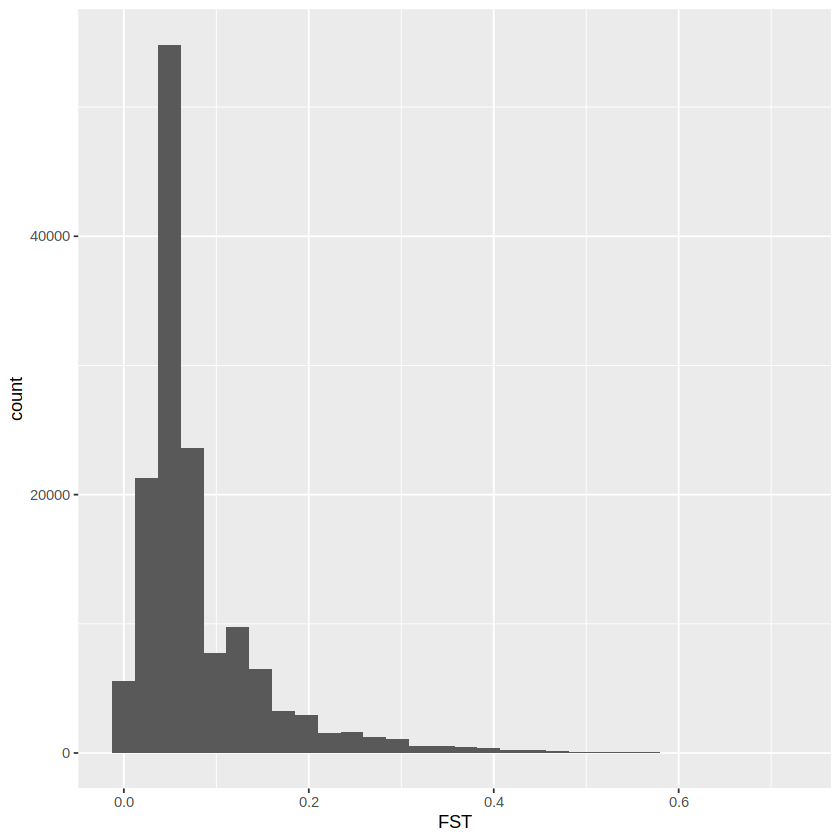

In [28]:
d2 %>%
    #filter(na!=0, nA!=0) %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_histogram(aes(x=FST))

### Q.7 Calculate `FST` using only the European and African samples and make a histogram of the values.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



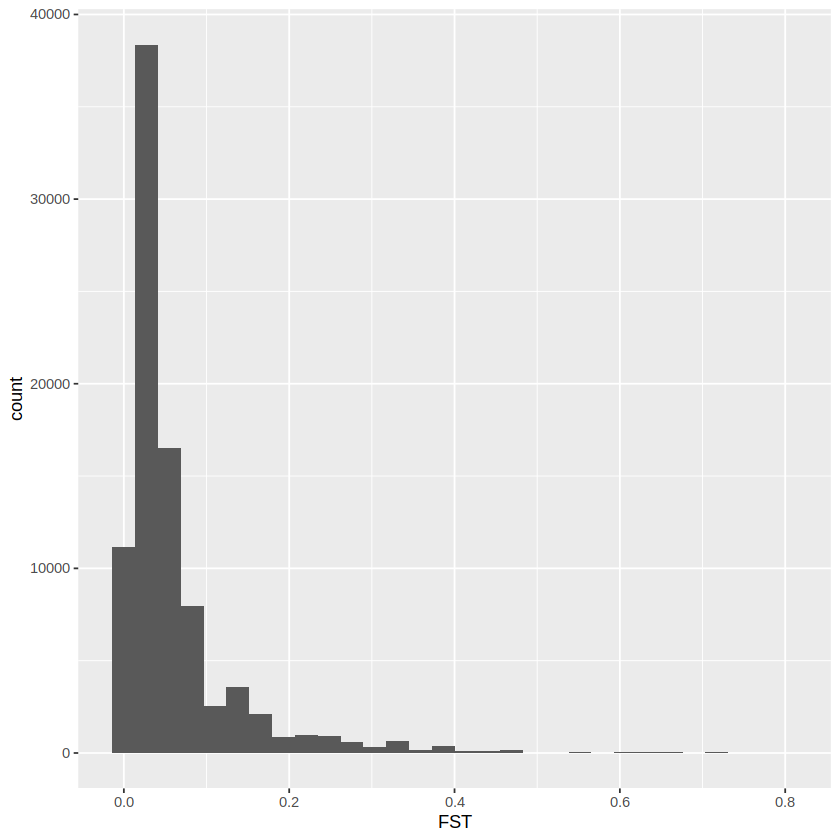

In [29]:
d2 %>%
    filter(region %in% c("WestEurasia","Africa")) %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_histogram(aes(x=FST))

### Q.8 Make a plot with the genomic position on the x axis and the `FST` value on the y axis. (Hint: use geom_point() or geom_line())

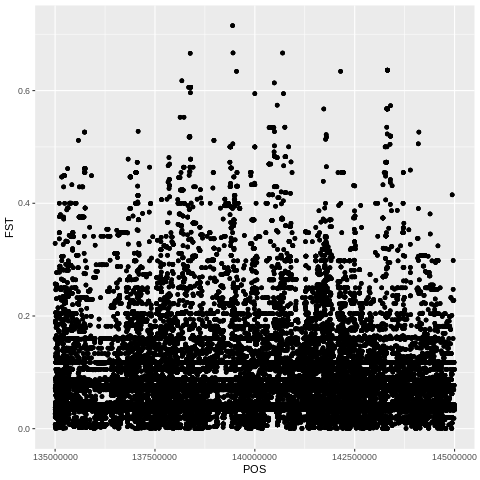

In [31]:
d2 %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_point(aes(x=POS,y=FST))

### Q.9 Make plots with average polymorphism and FST in bins along the genome.

We calculate bins using `mutate`, then group by bins and regions using `groupby`, and finally use `summarise` to count the number of lines in a bin, divided by how big the bin is, so that we calculate the fraction of polymorphic loci.

In [35]:
bin_width = 500000
d2 %>% 
  mutate(binmid=((POS %/% bin_width)*bin_width)) %>%
  filter(na!=0, nA!=0) %>%
  group_by(binmid, region) %>%
  summarise(frac_polymorph=n()/bin_width) %>%
  head(15)

`summarise()` has grouped output by 'binmid'. You can override using the
`.groups` argument.


binmid,region,frac_polymorph
<dbl>,<chr>,<dbl>
135000000,Africa,0.003682
135000000,EastAsia,0.001972
135000000,WestEurasia,0.002236
135500000,Africa,0.002764
135500000,EastAsia,0.001548
135500000,WestEurasia,0.001416
136000000,Africa,0.002484
136000000,EastAsia,0.001132
136000000,WestEurasia,0.001372


Here we do the same as above and plot the fraction of polymorphism for each population using `ggplot`

`summarise()` has grouped output by 'binmid'. You can override using the
`.groups` argument.


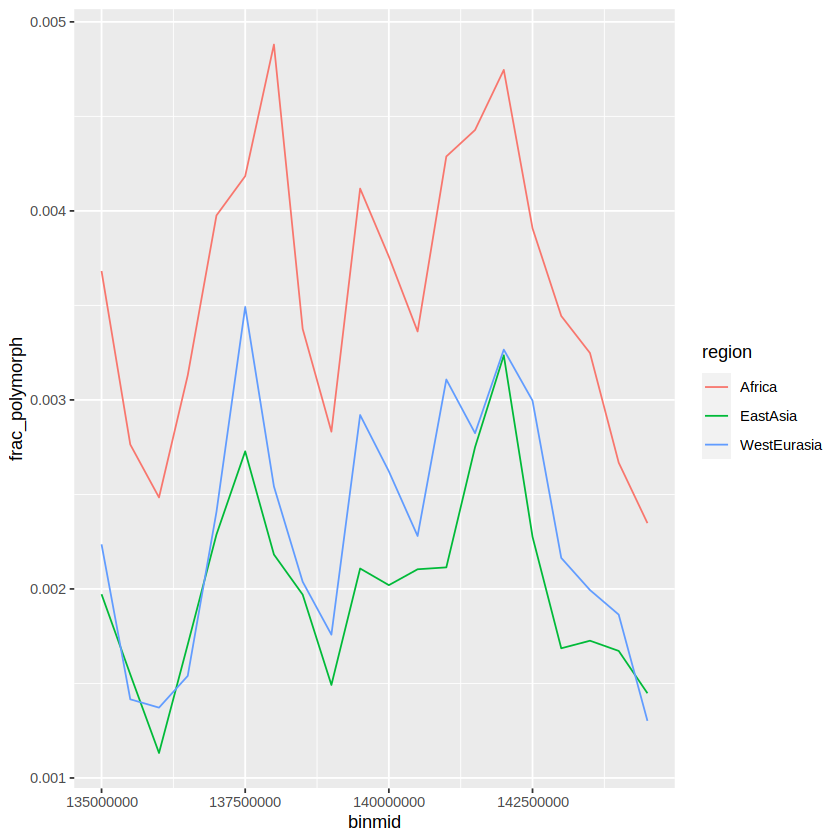

In [30]:
bin_width = 500000
d2 %>% 
  mutate(binmid=((POS %/% bin_width)*bin_width)) %>%
  filter(na!=0, nA!=0) %>%
  group_by(binmid, region) %>%
  summarise(frac_polymorph=n()/bin_width) %>%
  ggplot(aes(x=binmid, y=frac_polymorph, color=region)) + geom_line()

Below, we apply the code to calculate $F_st$ in each bin and do the plot

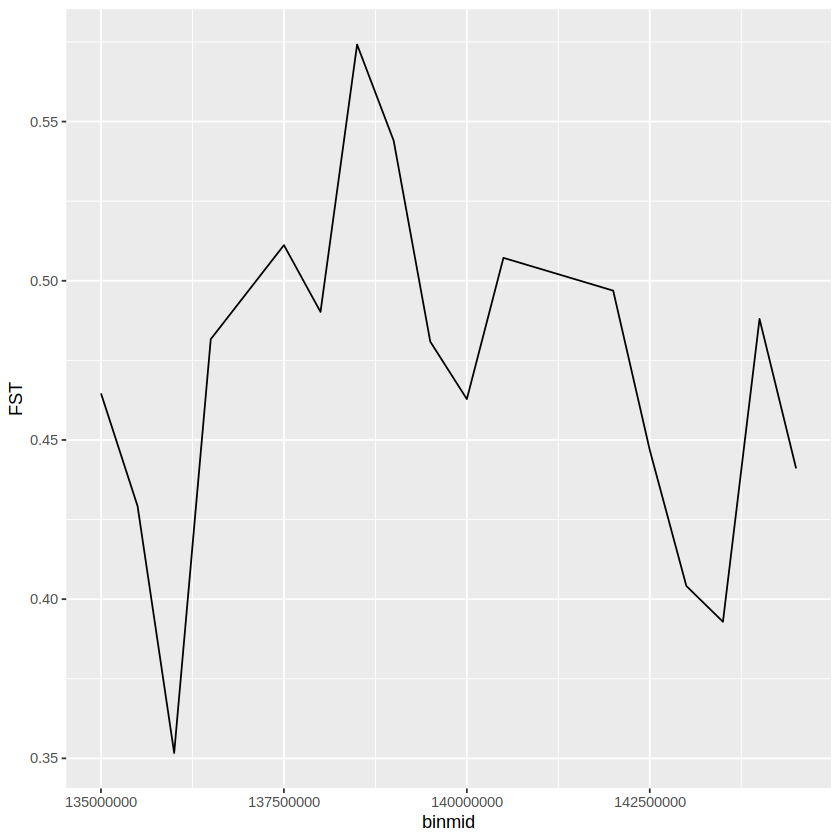

In [36]:
bin_width = 500000
d2 %>% 
    mutate(binmid=((POS %/% bin_width)*bin_width)) %>%
    group_by(binmid) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_line(aes(x=binmid,y=FST))